#### <div style = "color:white; font-weight:bold; background:black; text-align:center">Comprehensive Airline Default Prediction System Based on Financial Ratios and Stress Case Modelling.</div>
  This model provides a structured and transparent way to estimate the financial stability and potential default risk of airlines by analyzing their key financial ratios and testing their resilience under different economic scenarios. It combines liquidity, leverage, profitability, and efficiency indicators into a weighted scoring framework that produces an easy-to-interpret composite risk score.

  To capture real-world uncertainty, the model also applies stress scenarios—such as increases in fuel costs, drops in demand, or unfavorable currency movements—to show how each airline’s financial condition would change under adverse conditions.

  The result is a clear, data-driven view of which airlines are financially strong, which are vulnerable, and how external shocks could impact their creditworthiness. This framework is designed to be explainable, analytically rigorous, and suitable for investors, analysts, lenders, and academic research.
  

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff">1. Importing Libraries.</div>
  Below we load the required Python packages.

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff">2. Declaration of Airlines under consideration and Paths of the data source files.</div>
    
    

In [3]:
airlines = {
    "Ryanair": "RYA.IR",
    "Delta": "DAL",
    "easyJet": "EZJ.L",
    "Lufthansa": "LHA.DE",
    "AirAsiaX": "5238.KL"
}

# Correct datasheet path mapping
datasheet_path = {
    "RYA.IR": r"D:\New Project\Ryanair.xlsx",
    "DAL": r"D:\New Project\Delta.xlsx",
    "EZJ.L": r"D:\New Project\EasyJet.xlsx",
    "LHA.DE": r"D:\New Project\Lufthansa.xlsx",
    "5238.KL": r"D:\New Project\AirAsia.xlsx",
}

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">3. Data Download and Utility Functions.</div>
<div>This section loads the airline financial data and prepares it for analysis.</div></b>
<div>It includes small helper functions that safely handle missing or zero values while performing division operation</div>


In [4]:
def load_user_delta(path):
    if os.path.exists(path):
        try:
            x = pd.read_excel(path, sheet_name=None)
            print(f"Loaded {path} with sheets: {list(x.keys())}")
            return x
        except Exception as e:
            print("Error loading Delta.xlsx:", e)
            return None
    else:
        print(f"No user Delta file found at {path}")
        return None
    
def safe_div(a, b):
    try:
        a = float(a)
        b = float(b)
        if math.isfinite(a) and math.isfinite(b) and b != 0:
            return a / b
    except Exception:
        pass
    return np.nan

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">4. Function to search latest data field from the datasets.</div>

In [5]:
def get_latest_field(df, lookup_names, year_col='Year'):
    if df is None or df.empty:
        return np.nan

    # Find matching rows (substring allowed)
    mask = pd.Series(False, index=df.index)
    for name in lookup_names:
        mask |= df.index.str.contains(name, case=False, na=False)

    matched = df[mask]

    if matched.empty:
        return np.nan

    # Sort by Year and return the latest
    try:
        matched = matched.sort_values(by=year_col)
        val = matched.iloc[-1]['Value']   # or whichever column stores numbers
        return float(val)
    except:
        return np.nan


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">5. Main Ratio Computation Engine.</div>
<div> The following function compute all the financial ratios of <Span style = "font-weight:bold;color:green;">liquidity, leverage, profitability, efficiency and cash runway.</span> It can be modified for adding more criteria and ratios</div>

In [6]:
def compute_ratios_from_financials(fin_dict):
    """Given 'income','balance','cashflow','info' returns a pd.Series of ratios (latest available)."""
    inc = fin_dict.get('Income', pd.DataFrame()).set_index(['Indicator'])
    bal = fin_dict.get('Balance', pd.DataFrame()).set_index(['Indicator'])
    cf = fin_dict.get('Cash', pd.DataFrame()).set_index(['Indicator'])
    info = fin_dict.get('info', {})

    # Key fields (try multiple possible labels)
    rev = get_latest_field(inc, ['Total Revenue', 'Revenue', 'Revenues', 'Net revenue'])
    ebit = get_latest_field(inc, ['Operating Income', 'EBIT', 'Operating Profit'])
    ebitda = get_latest_field(inc, ['EBITDA', 'Ebitda'])
    net_income = get_latest_field(inc, ['Net Income', 'Net (Loss) Income'])
    total_assets = get_latest_field(bal, ['Total Assets', 'Assets'])
    cash = get_latest_field(bal, ['Cash And Cash Equivalents', 'Cash', 'Cash & Equivalents'])
    current_assets = get_latest_field(bal, ['Total Current Assets', 'Current Assets'])
    current_liabilities = get_latest_field(bal, ['Total Current Liabilities', 'Current Liabilities'])
    total_liabilities = get_latest_field(bal, ['Total Liab', 'Total Liabilities', 'Liabilities'])
    total_equity = get_latest_field(bal, ['Total Stockholder', 'Total Equity', 'Shareholders'])
    long_term_debt = get_latest_field(bal, ['Long Term Debt', 'Long-term Debt', 'Long-term debt'])
    short_term_debt = get_latest_field(bal, ['Short Term Debt', 'Short-term debt', 'Current maturities of long-term debt'])
    # estimate debt as sum of short+long if both present else use long-term as proxy
    debt = np.nan
    if not np.isnan(long_term_debt) and not np.isnan(short_term_debt):
        debt = long_term_debt + short_term_debt
    elif not np.isnan(long_term_debt):
        debt = long_term_debt
    else:
        debt = get_latest_field(bal, ['Total debt', 'Debt'])

    operating_cf = get_latest_field(cf, ['Total Cash From Operating Activities', 'Net cash provided by operating activities', 'Operating cash flow'])

    # Derived ratios
    ratios = {}
    ratios['Revenue'] = rev
    ratios['EBIT'] = ebit
    ratios['EBITDA'] = ebitda
    ratios['Net Income'] = net_income
    ratios['Total Assets'] = total_assets
    ratios['Cash'] = cash
    ratios['Current Assets'] = current_assets
    ratios['Current Liabilities'] = current_liabilities
    ratios['Total Liabilities'] = total_liabilities
    ratios['Total Equity'] = total_equity
    ratios['Debt (reported)'] = debt
    ratios['Operating Cash Flow'] = operating_cf

    ratios['Current Ratio'] = safe_div(current_assets, current_liabilities)
    inv = get_latest_field(bal, ['Inventory'])
    quick_assets = current_assets - (inv if not np.isnan(inv) else 0)
    ratios['Quick Ratio'] = safe_div(quick_assets, current_liabilities)
    ratios['Cash / Total Assets'] = safe_div(cash, total_assets)
    ratios['Operating CF / Current Liabilities'] = safe_div(operating_cf, current_liabilities)

    ratios['Total Debt / Equity'] = safe_div(debt, total_equity)
    ratios['Debt / Capital'] = safe_div(debt, (debt + total_equity) if not (np.isnan(debt) or np.isnan(total_equity)) else np.nan)
    ratios['Net Debt / EBITDA'] = np.nan
    if not np.isnan(debt) and not np.isnan(cash) and not np.isnan(ebitda) and ebitda != 0:
        ratios['Net Debt / EBITDA'] = safe_div((debt - cash), ebitda)

    ratios['EBITDA margin'] = safe_div(ebitda, rev)
    ratios['Operating margin'] = safe_div(ebit, rev)
    ratios['Net income margin'] = safe_div(net_income, rev)
    ratios['ROA'] = safe_div(net_income, total_assets)
    tax_rate = info.get('taxRate', 0.25)
    nopat = (ebit * (1 - tax_rate)) if not np.isnan(ebit) else np.nan
    ratios['ROIC (approx)'] = safe_div(nopat, (debt + total_equity) if not (np.isnan(debt) or np.isnan(total_equity)) else np.nan)

    ratios['Asset Turnover'] = safe_div(rev, total_assets)
    # Operational metrics possibly missing from yfinance: set NaN and allow user input
    ratios['Load Factor'] = np.nan
    ratios['RASK/CASK'] = np.nan

    # Cash burn & runway: approximate
    ratios['Quarterly cash burn (approx)'] = np.nan
    if not np.isnan(operating_cf):
        ratios['Quarterly cash burn (approx)'] = (-operating_cf / 4.0) if operating_cf < 0 else 0.0
    ratios['Cash Runway (months)'] = np.nan
    if not np.isnan(cash):
        qburn = ratios['Quarterly cash burn (approx)']
        if qburn and qburn > 0:
            ratios['Cash Runway (months)'] = safe_div(cash, qburn)
        else:
            ratios['Cash Runway (months)'] = np.inf

    return pd.Series(ratios)

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">6. Building the Ratio Table.</div> 
This section prepares the ratios dictionary for each airline that will be used for results.

In [7]:


# Create empty table
ratio_table = None
financials = {}

for name, ticker in airlines.items():

    # Load correct file
    fin = load_user_delta(datasheet_path[ticker])
    financials[name] = fin

    # Compute ratios
    ratios = compute_ratios_from_financials(fin)

    # Initialize ratio_table only once with columns
    if ratio_table is None:
        ratio_table = pd.DataFrame(columns=ratios.index)

    # Append ratio row
    ratio_table.loc[name] = ratios


Loaded D:\New Project\Ryanair.xlsx with sheets: ['Income', 'Income Statements', 'Balance', 'Balance Sheet', 'Cash', 'Cash Flow']


C:\Users\Merajul haque\AppData\Local\Temp\ipykernel_24568\2904446055.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask |= df.index.str.contains(name, case=False, na=False)


Loaded D:\New Project\Delta.xlsx with sheets: ['Income', 'Income Statement', 'Balance', 'Balance Sheet', 'Cash', 'Cash Flow']
Loaded D:\New Project\EasyJet.xlsx with sheets: ['Income', 'Profit', 'Balance', 'Balance Sheet', 'Cash', 'Cash Flow']
Loaded D:\New Project\Lufthansa.xlsx with sheets: ['Income', 'Income Statement', 'Balance', 'Balance Sheet', 'Cash', 'Cash Flow']


C:\Users\Merajul haque\AppData\Local\Temp\ipykernel_24568\2904446055.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask |= df.index.str.contains(name, case=False, na=False)
C:\Users\Merajul haque\AppData\Local\Temp\ipykernel_24568\2904446055.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask |= df.index.str.contains(name, case=False, na=False)
C:\Users\Merajul haque\AppData\Local\Temp\ipykernel_24568\2904446055.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask |= df.index.str.contains(name, case=False, na=False)


Loaded D:\New Project\AirAsia.xlsx with sheets: ['Income', 'Income Statement', 'Balance', 'Balance Sheet', 'Cash', 'Cash Flow']


C:\Users\Merajul haque\AppData\Local\Temp\ipykernel_24568\2904446055.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask |= df.index.str.contains(name, case=False, na=False)


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">7. Important matrices and ratios.</div> 

In [8]:
ratio_table

,Revenue,EBIT,EBITDA,Net Income,Total Assets,Cash,Current Assets,Current Liabilities,Total Liabilities,Total Equity,...,EBITDA margin,Operating margin,Net income margin,ROA,ROIC (approx),Asset Turnover,Load Factor,RASK/CASK,Quarterly cash burn (approx),Cash Runway (months)
Ryanair,15074.0,2404.00,3615.00,2359.0000,1637.00,2964.00,6010.00,8153.0,282.20,7037.00,...,0.239817,0.159480,0.156495,1.441051,0.206719,9.208308,NaN,NaN,NaN,inf
Delta,45960.0,6072.00,6575.00,4630.0000,75372.00,3069.00,9844.00,26670.0,60079.00,15293.00,...,0.143059,0.132115,0.100740,0.061429,0.249794,0.609776,NaN,NaN,NaN,inf
easyJet,6072.0,696.00,367.00,0.0929,567.00,1504.00,4625.00,4152.0,285.00,3498.00,...,0.060441,0.114625,0.000015,0.000164,0.097152,10.708995,NaN,NaN,0.0,inf
Lufthansa,32222.0,1444.00,3393.00,1664.0000,930.00,1371.00,17369.00,20448.0,1387.00,11420.00,...,0.105301,0.044814,0.051642,1.789247,0.052642,34.647312,NaN,NaN,0.0,inf
AirAsiaX,3293.0,245.58,253.14,113.7300,35.91,45.05,786.18,1273.0,305.75,441.34,...,0.076872,0.074576,0.034537,3.167084,0.417331,91.701476,NaN,NaN,0.0,inf


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">8. Ratios Analysis Engine/Scoring Framework.</div> 
Analyse the financial ratios and rank them based on the conditions.

In [9]:
weights = {'Liquidity': 0.40, 'Leverage': 0.30, 'Profitability': 0.20, 'Efficiency_Cash': 0.10}

def bucket_score_metric(value, buckets):
    """Given ascending buckets list of (threshold, score), return score. buckets sorted descending threshold->score expected."""
    if np.isnan(value):
        return np.nan
    for thresh, score in buckets:
        if value >= thresh:
            return score
    return 0

def score_airline(row):
    # Liquidty metrics (4 sub-items each 0-25)
    # Define thresholds for each metric (customizable)
    # Current Ratio buckets (>=2:25, >=1.5:20, >=1.0:12.5, >=0.7:6, else 0)
    cr = row.get('Current Ratio', np.nan)
    qr = row.get('Quick Ratio', np.nan)
    cash_ta = row.get('Cash / Total Assets', np.nan)
    ocf_cl = row.get('Operating CF / Current Liabilities', np.nan)

    def b_cr(x):
        if np.isnan(x): return 12.5
        if x >= 2.0: return 25
        if x >= 1.5: return 20
        if x >= 1.0: return 12.5
        if x >= 0.7: return 6
        return 0
    def b_qr(x):
        return b_cr(x) if True else 0
    def b_cash_ta(x):
        if np.isnan(x): return 12.5
        if x >= 0.08: return 25
        if x >= 0.05: return 18
        if x >= 0.02: return 10
        if x >= 0.01: return 4
        return 0
    def b_ocf_cl(x):
        if np.isnan(x): return 12.5
        if x >= 0.5: return 25
        if x >= 0.25: return 18
        if x >= 0.1: return 10
        if x >= 0: return 4
        return 0

    liq_raw = b_cr(cr) + b_qr(qr) + b_cash_ta(cash_ta) + b_ocf_cl(ocf_cl)
    liq_weighted = liq_raw * weights['Liquidity']

    # Leverage metrics: Total Debt/Equity, Net Debt/EBITDA, Debt/Capital (each 0-33.33 approx)
    tde = row.get('Total Debt / Equity', np.nan)
    nde = row.get('Net Debt / EBITDA', np.nan)
    dc = row.get('Debt / Capital', np.nan)
    def b_leverage(x):
        if np.isnan(x): return 12.5
        if x <= 0.25: return 25
        if x <= 0.5: return 20
        if x <= 1.0: return 12.5
        if x <= 2.0: return 6
        return 0
    lev_raw = b_leverage(tde) + b_leverage(nde) + b_leverage(dc)
    lev_weighted = lev_raw * weights['Leverage']

    # Profitability: EBITDA margin, Operating margin, Net margin, ROA
    ebm = row.get('EBITDA margin', np.nan)
    opm = row.get('Operating margin', np.nan)
    npm = row.get('Net income margin', np.nan)
    roa = row.get('ROA', np.nan)
    def b_profit(x):
        if np.isnan(x): return 12.5
        if x >= 0.20: return 25
        if x >= 0.12: return 20
        if x >= 0.05: return 12.5
        if x >= 0: return 6
        return 0
    prof_raw = b_profit(ebm) + b_profit(opm) + b_profit(npm) + b_profit(roa)
    prof_weighted = prof_raw * weights['Profitability']

    # Efficiency & Cash: Asset turnover, Load factor, Cash runway
    at = row.get('Asset Turnover', np.nan)
    lf = row.get('Load Factor', np.nan)
    runway = row.get('Cash Runway (months)', np.nan)
    def b_eff_asset(x):
        if np.isnan(x): return 12.5
        if x >= 0.6: return 25
        if x >= 0.4: return 18
        if x >= 0.2: return 10
        if x >= 0.1: return 4
        return 0
    def b_eff_load(x):
        if np.isnan(x): return 12.5
        if x >= 0.80: return 25
        if x >= 0.75: return 18
        if x >= 0.70: return 10
        if x >= 0.60: return 4
        return 0
    def b_eff_runway(x):
        if np.isnan(x): return 12.5
        if x == np.inf: return 25
        if x >= 18: return 25
        if x >= 12: return 18
        if x >= 6: return 10
        if x >= 3: return 4
        return 0

    eff_raw = b_eff_asset(at) + b_eff_load(lf) + b_eff_runway(runway)
    eff_weighted = eff_raw * weights['Efficiency_Cash']

    composite = liq_weighted + lev_weighted + prof_weighted + eff_weighted
    return {
        'liq_raw': liq_raw, 'lev_raw': lev_raw, 'prof_raw': prof_raw, 'eff_raw': eff_raw,
        'liq_weighted': liq_weighted, 'lev_weighted': lev_weighted, 'prof_weighted': prof_weighted, 'eff_weighted': eff_weighted,
        'composite_score': composite
    }

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">9. Ratio Analysis.</div> 

In [10]:
# Compute baseline scores
baseline_scores = {}
for name, row in ratio_table.iterrows():
    baseline_scores[name] = score_airline(row)
baseline_df = pd.DataFrame(baseline_scores).T
print("Raw baseline score and weighted raw ratios:")
print()
baseline_scores_df = pd.DataFrame(baseline_scores)
baseline_scores_df.index.name = 'Ratios'
print(baseline_scores_df)
baseline_df['composite_score'] = baseline_df['composite_score'].round(3)
baseline_df = baseline_df.sort_values('composite_score', ascending=False)
print()
print("Baseline composite scores (0 = worst, 100 = best):\ncalculated using the weighted ratio of 40:30:20:10 ")
print()
print(baseline_df[['composite_score']])


Raw baseline score and weighted raw ratios:

                 Ryanair  Delta  easyJet  Lufthansa  AirAsiaX
Ratios                                                       
liq_raw            49.50  22.50    54.00      41.00     29.00
lev_raw            75.00  75.00    38.50      32.50     75.00
prof_raw           90.00  65.00    37.00      56.00     56.00
eff_raw            62.50  62.50    62.50      62.50     62.50
liq_weighted       19.80   9.00    21.60      16.40     11.60
lev_weighted       22.50  22.50    11.55       9.75     22.50
prof_weighted      18.00  13.00     7.40      11.20     11.20
eff_weighted        6.25   6.25     6.25       6.25      6.25
composite_score    66.55  50.75    46.80      43.60     51.55

Baseline composite scores (0 = worst, 100 = best):
calculated using the weighted ratio of 40:30:20:10 

           composite_score
Ryanair              66.55
AirAsiaX             51.55
Delta                50.75
easyJet              46.80
Lufthansa            43.60


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">10. Ratio Table.</div> 

In [11]:
baseline_df.index.name = "Airlines"
baseline_df


,liq_raw,lev_raw,prof_raw,eff_raw,liq_weighted,lev_weighted,prof_weighted,eff_weighted,composite_score
Airlines,,,,,,,,,
Ryanair,49.5,75.0,90.0,62.5,19.8,22.50,18.0,6.25,66.55
AirAsiaX,29.0,75.0,56.0,62.5,11.6,22.50,11.2,6.25,51.55
Delta,22.5,75.0,65.0,62.5,9.0,22.50,13.0,6.25,50.75
easyJet,54.0,38.5,37.0,62.5,21.6,11.55,7.4,6.25,46.80
Lufthansa,41.0,32.5,56.0,62.5,16.4,9.75,11.2,6.25,43.60


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">11. Scenario Analysis Engine.</div> 
This engine convert the financial matrices and ratios according to scenario defined in the senario declaration section.

In [12]:
# ---- Scenario functions ----
def apply_scenario_to_row(row, scenario):
    """
    scenario keys: fuel_pct (0.15 for +15%), demand_pct (-0.08 for -8%), fx_pct (-0.05 for -5%), margin_comp (absolute e.g. 0.025)
    This function returns an adjusted copy of the row with heuristic changes to margins, revenue and runway.
    """
    s = row.copy()
    demand = scenario.get('demand_pct', 0.0)
    fuel = scenario.get('fuel_pct', 0.0)
    fx = scenario.get('fx_pct', 0.0)
    margin_comp = scenario.get('margin_comp', 0.0)

    # Revenue falls by demand shock
    if not np.isnan(s['Revenue']):
        s['Revenue'] = s['Revenue'] * (1 + demand)
    # margin compression reduces EBITDA margin
    if not np.isnan(s.get('EBITDA margin', np.nan)):
        s['EBITDA margin'] = s['EBITDA margin'] - margin_comp
        s['EBITDA'] = s['Revenue'] * s['EBITDA margin'] if not np.isnan(s['Revenue']) else np.nan
    # fuel increases reduce margins further (approx translate fuel_pct -> margin hit of fuel_pct * 0.20)
    fuel_hit = fuel * 0.20
    if not np.isnan(s.get('EBITDA margin', np.nan)):
        s['EBITDA margin'] = s['EBITDA margin'] - fuel_hit
        s['EBITDA'] = s['Revenue'] * s['EBITDA margin'] if not np.isnan(s['Revenue']) else np.nan
    # FX impacts net income roughly
    if not np.isnan(s.get('Net Income', np.nan)):
        s['Net Income'] = s['Net Income'] * (1 + fx)
    # Cash runway shrinks if margins / demand degrade
    if np.isfinite(s.get('Cash Runway (months)', np.nan)):
        runway = s['Cash Runway (months)']
        if runway != np.inf and not np.isnan(runway):
            runway_adj = runway * (1 + demand - fuel*0.5 - margin_comp)  # heuristic
            s['Cash Runway (months)'] = max(0.0, runway_adj)
    # Recompute derived ratio Asset Turnover
    if not np.isnan(s.get('Revenue', np.nan)) and not np.isnan(s.get('Total Assets', np.nan)):
        s['Asset Turnover'] = safe_div(s['Revenue'], s['Total Assets'])
    return s

##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">12. Senario Declaration and Analysis.</div> 

In [13]:
scenarios = {
    'Base': {'fuel_pct': 0.0, 'demand_pct': 0.0, 'fx_pct': 0.0, 'margin_comp': 0.0},
    'Downside': {'fuel_pct': 0.15, 'demand_pct': -0.08, 'fx_pct': -0.05, 'margin_comp': 0.025},
    'Severe': {'fuel_pct': 0.30, 'demand_pct': -0.20, 'fx_pct': -0.10, 'margin_comp': 0.05}
}

scenario_scores = {}
for sname, scen in scenarios.items():
    rows = []
    for name, row in ratio_table.iterrows():
        adj = apply_scenario_to_row(row, scen)
        sc = score_airline(adj)
        rows.append((name, sc['composite_score']))
    scenario_scores[sname] = pd.DataFrame(rows, columns=['Airline', 'composite_score']).set_index('Airline')['composite_score']

scenario_df = pd.concat(scenario_scores, axis=1)
scenario_df.columns = list(scenarios.keys())
scenario_df = scenario_df.round(3)
print("Scenario scores (0-100):")
print()
print(scenario_df)

Scenario scores (0-100):

            Base  Downside  Severe
Airline                           
Ryanair    66.55     65.55   65.55
Delta      50.75     48.55   47.25
easyJet    46.80     45.50   44.30
Lufthansa  43.60     43.60   41.10
AirAsiaX   51.55     50.25   49.05


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">13. Scenario Result.</div> 

In [14]:
scenario_df

,Base,Downside,Severe
Airline,,,
Ryanair,66.55,65.55,65.55
Delta,50.75,48.55,47.25
easyJet,46.80,45.50,44.30
Lufthansa,43.60,43.60,41.10
AirAsiaX,51.55,50.25,49.05


##### <div style = "color:#0b3d91; font-weight:bold; background:#e8f1ff;">14. Visualisation of result.</div> 

##### <div style="color:black; font-style:italic; background:#d9f7e3; padding-left:60px;text-align:center">Final Score and Risk.</div>


In [15]:
# ---- Risk ranking and heatmap ----
ranking = scenario_df['Base'].sort_values(ascending=False).reset_index()
def score_to_risk(score):
    if score >= 75: return 'Low'
    if score >= 60: return 'Moderate'
    if score >= 45: return 'Elevated'
    if score >= 30: return 'High'
    return 'Very High'
ranking['RiskBand'] = ranking['Base'].apply(score_to_risk)
ranking.set_index("Airline")


,Base,RiskBand
Airline,,
Ryanair,66.55,Moderate
AirAsiaX,51.55,Elevated
Delta,50.75,Elevated
easyJet,46.80,Elevated
Lufthansa,43.60,High


##### <div style="color:black; font-style:italic; background:#d9f7e3; padding-left:60px;text-align:center">Visualization of result using <span style = "font-weight:bold;color:green">Heatmap</span>.</div> 

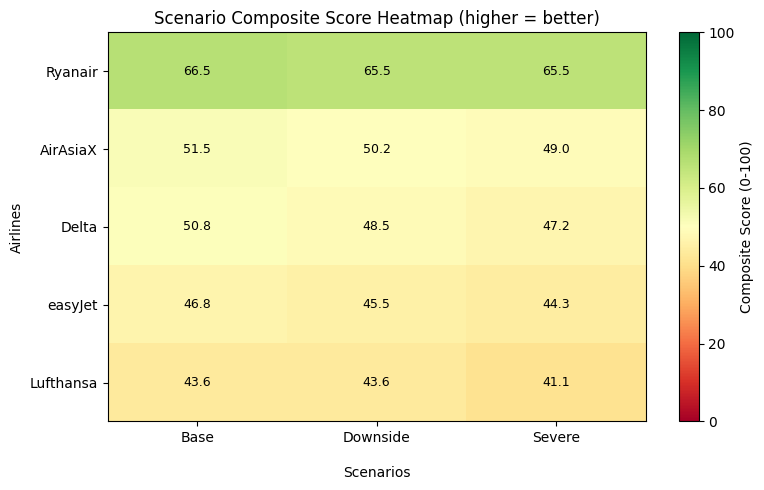

In [16]:
# Heatmap (matplotlib)
order = ranking['Airline'].tolist()
data = scenario_df.loc[order].values
fig, ax = plt.subplots(figsize=(8, 3 + len(order)*0.4))
cmap = plt.get_cmap('RdYlGn')  # red->yellow->green
img = ax.imshow(data, aspect='auto', vmin=0, vmax=100, cmap=cmap)
ax.set_yticks(np.arange(len(order)))
ax.set_yticklabels(order)
ax.set_xticks(np.arange(len(scenario_df.columns)))
ax.set_xticklabels(scenario_df.columns)
for i in range(len(order)):
    for j in range(len(scenario_df.columns)):
        ax.text(j, i, f"{data[i,j]:.1f}", ha='center', va='center', fontsize=9)
plt.colorbar(img, ax=ax, label='Composite Score (0-100)')
ax.set_title('Scenario Composite Score Heatmap (higher = better)')
ax.set_ylabel("Airlines",loc="center")
ax.set_xlabel("Scenarios",loc="center",labelpad=15)
plt.tight_layout()
plt.show()

##### <div style="color:black; font-style:italic; background:#d9f7e3; padding-left:60px;text-align:center">Summary of the result.</div> 

In [22]:
ranking

,Airline,Base,RiskBand
0,Ryanair,66.55,Moderate
1,AirAsiaX,51.55,Elevated
2,Delta,50.75,Elevated
3,easyJet,46.80,Elevated
4,Lufthansa,43.60,High


In [21]:
print("\nScenario Impact Summary\n" + "-"*75)
print(f"{'Airline':<12} {'Base':>8} {'Downside':>12} {'Δ Down':>10} {'Severe':>10} {'Δ Severe':>10}")
print("-"*75)

for name in ranking['Airline']:
    base = scenario_df.loc[name, 'Base']
    down = scenario_df.loc[name, 'Downside']
    sev = scenario_df.loc[name, 'Severe']

    print(f"{name:<12} {base:>8.1f} {down:>12.1f} {down-base:>10.1f} {sev:>10.1f} {sev-base:>10.1f}")

print("-"*75)




Scenario Impact Summary
---------------------------------------------------------------------------
Airline          Base     Downside     Δ Down     Severe   Δ Severe
---------------------------------------------------------------------------
Ryanair          66.5         65.5       -1.0       65.5       -1.0
AirAsiaX         51.5         50.2       -1.3       49.0       -2.5
Delta            50.8         48.5       -2.2       47.2       -3.5
easyJet          46.8         45.5       -1.3       44.3       -2.5
Lufthansa        43.6         43.6        0.0       41.1       -2.5
---------------------------------------------------------------------------


In [18]:
def generate_auto_summary(summary_table):
    """
    Automatically generates a clean analytical text summary based on:
    - Base scenario ranking
    - Score drops in Downside and Severe
    - Sensitivity of each airline
    - Stability behavior across scenarios
    """

    # Extract values
    airlines = summary_table['Airline'].tolist()
    base_scores = summary_table['Base']
    down_scores = summary_table['Downside']
    sev_scores = summary_table['Severe']

    # Identify strongest/weakest airlines
    strongest = summary_table.loc[summary_table['Base'].idxmax(), 'Airline']
    weakest = summary_table.loc[summary_table['Base'].idxmin(), 'Airline']

    # Average scenario impacts
    avg_down_drop = (down_scores - base_scores).mean()
    avg_sev_drop = (sev_scores - base_scores).mean()

    # Sensitivity calculations
    delta_sev = sev_scores - base_scores
    most_sensitive = summary_table.loc[delta_sev.idxmin(), 'Airline']
    least_sensitive = summary_table.loc[delta_sev.idxmax(), 'Airline']

    # Begin summary text
    print("\n" + "="*75)
    print("AUTOMATED MODEL SUMMARY")
    print("="*75 + "\n")

    print(f"• In the Base scenario, **{strongest}** ranks as the strongest airline in terms "
          f"of financial resilience, while **{weakest}** shows the weakest position.\n")

    print(f"• On average, airline scores fall by **{avg_down_drop:.1f} points** in the "
          f"Downside case and **{avg_sev_drop:.1f} points** in the Severe scenario, "
          "indicating moderate but noticeable vulnerability under stress.\n")

    print(f"• The airline most sensitive to Severe stress is **{most_sensitive}**, showing the "
          f"largest deterioration from Base to Severe. The least sensitive is **{least_sensitive}**, "
          "indicating relatively stable performance under adverse conditions.\n")

    # Airline-by-Airline Behavior
    print("• **Airline-specific scenario behavior:**")
    print()
    for idx, row in summary_table.iterrows():
        print(f"   - {row['Airline']}: Base {row['Base']:.1f}, Downside {row['Downside']:.1f} "
              f"(Δ {row['Δ Downside']:+.1f}), Severe {row['Severe']:.1f} "
              f"(Δ {row['Δ Severe']:+.1f})")

    print("\nOverall, the results show that while airlines remain mostly stable under moderate "
          "stress, the Severe scenario reveals deeper vulnerabilities—particularly for those "
          "with tighter margins or weaker liquidity structures. The stress test highlights the "
          "importance of maintaining robust financial buffers to absorb adverse shocks.\n")

    print("="*75)



<div style="color:black; font-style:italic; background:#d9f7e3; padding:12px; text-align:center; font-size:18px;">
    Final Insight / Summary
</div>

<div style="color:black; font-style:italic; background:#d9f7e3; padding:6px 12px; text-align:center; font-size:13px;">
    Note: The insights in this section depend on current scenario outputs and may vary with each run.
</div>


In [19]:
final = scenario_df.reset_index()
final["Δ Downside"]=final['Downside']-final["Base"]
final["Δ Severe"]=final["Severe"]-final["Base"]
generate_auto_summary(final)


AUTOMATED MODEL SUMMARY

• In the Base scenario, **Ryanair** ranks as the strongest airline in terms of financial resilience, while **Lufthansa** shows the weakest position.

• On average, airline scores fall by **-1.2 points** in the Downside case and **-2.4 points** in the Severe scenario, indicating moderate but noticeable vulnerability under stress.

• The airline most sensitive to Severe stress is **Delta**, showing the largest deterioration from Base to Severe. The least sensitive is **Ryanair**, indicating relatively stable performance under adverse conditions.

• **Airline-specific scenario behavior:**

   - Ryanair: Base 66.5, Downside 65.5 (Δ -1.0), Severe 65.5 (Δ -1.0)
   - Delta: Base 50.8, Downside 48.5 (Δ -2.2), Severe 47.2 (Δ -3.5)
   - easyJet: Base 46.8, Downside 45.5 (Δ -1.3), Severe 44.3 (Δ -2.5)
   - Lufthansa: Base 43.6, Downside 43.6 (Δ +0.0), Severe 41.1 (Δ -2.5)
   - AirAsiaX: Base 51.5, Downside 50.2 (Δ -1.3), Severe 49.0 (Δ -2.5)

Overall, the results show th

#### <div style="color:white;background:black"> Save output into excel files. </div>

In [20]:
# ---- Save outputs ----
# --- Change the location as required ----

OUTPUT_DIR = r"D:\New Project\Result"
scenario_df.to_csv(os.path.join(OUTPUT_DIR, "scenario_scores.csv"))
baseline_df.to_csv(os.path.join(OUTPUT_DIR, "baseline_component_scores.csv"))
print("Saved CSV outputs to", OUTPUT_DIR)

Saved CSV outputs to D:\New Project\Result
